This notebook solves the Extended Shallow Water Equations using the Shannon-Gibbs maximum Entropy velocity profile

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 12
plt.rc('axes', labelsize=20) 
plt.set_cmap('coolwarm')

<Figure size 720x360 with 0 Axes>

In [12]:
def diff_term():
    u_s = 1
    du = 0.001
    uu = np.arange(0,u_s,du) #velocity space

    #parameters for the parameter sweep of our velocity profile
    d_lam = 1
    lam_lim_lower = 20
    lam_lim_upper = 20
    lam_1, lam_2 = np.meshgrid(np.arange(-lam_lim_lower,lam_lim_upper,d_lam),np.arange(-lam_lim_lower,lam_lim_upper,d_lam))

    #arrays to be populated
    u_bar = np.ones(lam_1.shape)
    chi2 = np.ones(lam_1.shape)
    ediffEnt_sweep = np.ones(lam_1.shape)
    tauzEnt_sweep = np.ones(lam_1.shape)

    for i in range(0,lam_1.shape[0]):
        for j in range(0,lam_2.shape[1]):
            lam_1i = lam_1[i,j]
            lam_2j = lam_2[i,j]
            f = np.exp(-uu**2*lam_1i + uu**3*lam_2j) #distribution function
            f /= np.trapz(f)*du #normalizing

            #finding mean velocity:          
            u_bar[i,j] = np.trapz(f*uu)*du

            #shape_factor
            chi2[i,j] = np.trapz(f*uu*uu)*du/u_bar[i,j]**2

            #energy diffusion:
            ediffEnt_sweep[i,j] = np.trapz(1/f)*du

            #basal shear
            tauzEnt_sweep[i,j] = 1/f[0]

    #creating interpolating functions for energy diffusion and basal shear
    ediffEnt = interpolate.LinearNDInterpolator(list(zip(u_bar.flatten(),chi2.flatten())),ediffEnt_sweep.flatten(),fill_value = 0)
    tauzEnt = interpolate.LinearNDInterpolator(list(zip(u_bar.flatten(),chi2.flatten())),tauzEnt_sweep.flatten(),fill_value = 0)


    return tauzEnt, ediffEnt

In [13]:
Q = 1 #mass flow rate
g_x = 0.25 #horizontal component of gravity
g_z = 0.25#vertical component of gravity
U = 1.843
H = 0.541

#non dimensionalising g:
Fr = U/np.sqrt(g_z*H)
print('Froude')
print(Fr**2)
g_x *= H/U**2 
g_z *= H/U**2 
""" g_x = g_x/Fr**2
g_z = g_z/Fr**2 """

nu = 1e-2 #kinematic viscosity

Re = U*H/nu
print('Reynolds')
print(Re)

Re1 = 1/Re

dx = (1/100)/H #grid scale
L = 15 #domain length


p = 2.5 #power law for chi2/chi3
chi0 = 1.00
xx = np.arange(0,L,dx) - dx #grid
xxd = np.arange(0,2000*dx,dx)-10/H
xxOF = 0.8*(np.arange(0,20,1/80)-10)/H

#initializing vector of primatives:
W = np.zeros((3,xx.shape[0]))


#generating non-sonservative terms interpolation functions
Enttauzz, Entediff = diff_term()


#number of grid points away from the discontinuity to start the simulation:
N_start = 800 #+ 10 
#the reason we may wish to change this is because at the discontinuity, OpenFOAM does
#not perfectly conserve mass, there is instead a ~0.5% error, which can be eliminated by
#offsetting the start of the ESWE simulation by 10 grid points or so.
#The ESWE solution still gives reasonable results when N_start = 0.

discont = 0 #number of grid points until the discontinuity

#using initial conditions from OpenFOAM simulation
W[0,:] = 1
W[1,:] = 0.99
W[2,:] = 1.001
#W[0,1] = EnthOF[discont + N_start ]

#vector of non-conservative terms:
Tau = np.zeros((3,1))

#solving
for i in range(2,xx.shape[0]):
    #populating vector of non-conservative terms
    Tau[0,0] = 0
    
    #using interpolation from the maximum entropy velocity profile to find basal shear stress and energy diffusion


    #Tau[1,0] = 0 + g_x*W[0,i-1] - 1*Re1*(W[1,i-1]/W[0,i-1])*np.interp(W[2,i-1],Entchi2,Enttauzz) 
    #Tau[2,0] = 0 + 2*g_x*W[1,i-1]*W[0,i-1] - 2*Re1*(W[1,i-1]*W[1,i-1]/W[0,i-1])*np.interp(W[2,i-1],Entchi2,Entediff)

    Tau[1,0] = 0 + g_x*W[0,i-1] - 1*Re1*(W[1,i-1]/W[0,i-1])*Enttauzz(W[1,i-1]/W[0,i-1],W[2,i-1])
    Tau[2,0] = 0 + 2*g_x*W[1,i-1]*W[0,i-1] - 2*Re1*(W[1,i-1]*W[1,i-1]/W[0,i-1])*Entediff(W[1,i-1]/W[0,i-1],W[2,i-1])
    #print(Tau)
    #plt.pause(1)

    #building Flux matrix such that:
    #A(W)*dW/dx = Tau
    h = W[0,i-1] + 0
    u = W[1,i-1] + 0
    chi_2 = W[2,i-1]  + 0


    A = np.matrix([[u, chi_2*u**2 + 1.0*g_z*h, chi_2**p*u**3 + 4*g_z*h*u], [h, 2*chi_2*h*u, 3*chi_2**p*h*u**2 + 2*g_z*h**2], [0, h*u**2, chi_2**p*h*p*u**3/chi_2]]).transpose()
    B = np.zeros((3,3))
    B[1,0] = 0.5*Re1
    B[2,0] = 0.5*Re1
    B[2,1] = -0.5*chi_2*Re1
    B *= 0
    A /= dx
    B /= dx**2
    
    #solving explicit Euler
    RHS = Tau + np.matmul(B,W[:,i-2:i-1] - 2*W[:,i-1:i]) + np.matmul(A,W[:,i-1:i])
    W[:,i:i+1] = np.linalg.solve(A - B, RHS)

Froude
25.11385582255083
Reynolds
99.7063


Text(0, 0.5, '$\\chi_2$')

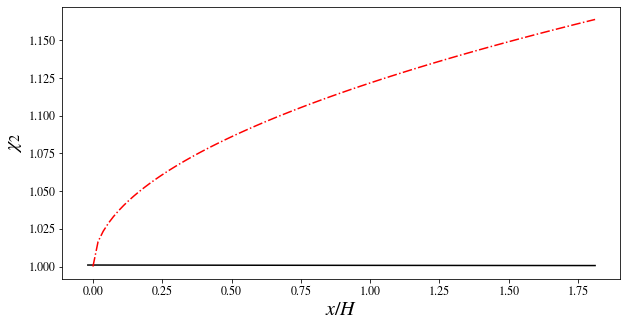

In [14]:
Q = 0.99
c = 1.72
plt.rcParams["figure.figsize"] = (10,5)

#Tsang Model
chi2Tsang = 1 + c*Re**(-0.5)*(xx/2)**(0.5)
chi2Tsang[chi2Tsang>1.3] = np.nan

#plotting shape-factor
N_points_plot = 100
plt.plot(xx[0:N_points_plot],W[2,0:N_points_plot],color = 'k')
plt.plot(xx[0:N_points_plot],chi2Tsang[0:N_points_plot],'-.', color = 'r')
#plt.plot(xx,W[0,:]*0+1.2,':', color = 'b')
plt.xlabel('$x/H$')
plt.ylabel('$\\chi_2$')